# Quantum circuit optimization with pruning

In this demo, we present a quantum circuit optimization with pruning which successfully reduces the number of one- and two- qubit parameterized gates of the variational quantum circuit up to a significant degree while remaining within chemical accuracy.

Interestingly, the given parameter optimization method works independent of the Hamiltonian of the system and its symmetries. 

We start by an overparametrized circuit and gradually reduce the parameters by pruning the gates that are close to the Identity operator at each pruning run and use jax to speed-up the otpimization process.

The main goal of this tutorial is to show that the idea of pruning that comes from classical neural networks works also well for quantum variational circuits and leads to parametrized quantum circuits with a significant less number of parameters while remaining within chemical accuracy!

In [1]:
import pennylane as qml
from pennylane import math
from math import pi
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import numpy as np
import jax.numpy as jnp

from jax import random
import scipy

### BeH2 Hamiltonian

Here, we define the problem Hamiltonian. We used the same Hamiltonian of the BeH2 molecule computed in the recent work of <a href="https://www.nature.com/articles/nature23879" title="link"> Kandala et. al. </a>  which kindly provided us with the BeH2 molecular Hamiltonian.

In [2]:
# here, we transform the hamiltonian to a format readable by PennyLane

obs_BeH2 = []
with open("BeH2_Hamiltonian.txt") as fileobj:
    i = 0
    for line in fileobj:  
        if (i % 2 == 0 ):
            qubit = 0
            list_line_obs = []
            for ch in line: 
                if (str(ch) == "I"):
                    obsI = qml.Identity(qubit)
                    list_line_obs.append(obsI)
                if (str(ch) == "Z"):
                    obsZ = qml.PauliZ(qubit)
                    list_line_obs.append(obsZ)
                if (str(ch) == "X"):
                    obsX = qml.PauliX(qubit)
                    list_line_obs.append(obsX)
                if (str(ch) == "Y"):
                    obsY = qml.PauliY(qubit)
                    list_line_obs.append(obsY)

                qubit += 1
            obs_BeH2.append(list_line_obs[0]@list_line_obs[1]@list_line_obs[2]@list_line_obs[3]@list_line_obs[4]@list_line_obs[5])
        i += 1
        
coeffs_BeH2 = []
with open("BeH2_Hamiltonian.txt") as fileobj:
    i = 0
    for line in fileobj:  
        if (i % 2 != 0 ):
            #print (line)
            coeffs_BeH2.append(float(line))
        i += 1

In [3]:
hamiltonian = qml.Hamiltonian(coeffs_BeH2, obs_BeH2)

### Exact global minimum

In [4]:
Ham = qml.utils.sparse_hamiltonian(hamiltonian)

In [5]:
eigenvalues, eigenvectors = scipy.linalg.eigh(Ham.toarray())

In [7]:
global_min = eigenvalues[0]
print (global_min)

-3.972747867902873


### hyper-parameters of the circuit architecture and the optimization procedure

In [8]:
qubits = 6 # number of qubits
number_layers = 30 # number of layers used
number_parameters = 17 # number of parameters at each layer
precentage = 0.025 # number of parameters pruned at each run
exps = 1 # number of independent pruning optimization
steps = 5000 # number of iterations at each optimization
total_pruning_runs = 20 # number of prunings applied in a single experiment
ekey = 1 # related to the initial values used

print ("total number of parameters:", number_layers*number_parameters)

with open('hyperparameters.txt', 'a+') as f:
    print (qubits, file=f)
    print (number_layers, file=f)
    print (number_parameters, file=f)
    print (precentage, file=f)
    print (exps, file=f)
    print (steps, file=f)
    print (total_pruning_runs, file=f)
    print (ekey, file=f)
f.close()

total number of parameters: 510


With a total number of 510 parameters including one and two qubit gates, we start with a highly overparameterize quantum circuit for the 6-qubit case.

### Variational quantum circuit

Here, we define a variational quantum circuit where each signle- and two- qubit gate is parameterized. The circuit architecture is inspired by the recent work of <a href="https://arxiv.org/abs/1905.10876" title="link"> P. D. Johnson et. al. </a>.

In [9]:
dev = qml.device("default.qubit", wires=qubits)
@jax.jit
@qml.qnode(dev, interface="jax")
def circuit_all(parameters):
    for i in range(0, number_layers):
        for j in range (0, qubits):
            qml.RX(parameters[i][j], wires = j)
        for j in range (0, qubits):
            qml.RZ(parameters[i][j+qubits], wires = j)
        qml.CRX(parameters[i][12], wires = [5, 4])
        qml.CRX(parameters[i][13], wires = [1, 0])
        qml.CRX(parameters[i][14], wires = [2, 1])
        qml.CRX(parameters[i][15], wires = [4, 3])
        qml.CRX(parameters[i][16], wires = [3, 2])
    return qml.expval(hamiltonian)

### Mask of parameters

To faciliate the optimization with jax, we create a vector that contains all the parameters and at each pruning run we create a relevat mask that silences the parameters of the corresponding gates that are pruned.

In [10]:
def create_mask(parameters, times):
    ppa = jnp.reshape(parameters, (1, number_layers*number_parameters)) # all the parameters
    sorted_ppa = abs(ppa[0]).sort()
    cut_off = int(precentage*len(sorted_ppa))
    
    non_zero_params = len(sorted_ppa) - 2*cut_off
    
    # defines the number of parameters that need to be masked
    for i in range(1, times):
        cut_off += round(precentage*non_zero_params)
        
    bound1 = sorted_ppa[cut_off]
    bound2 = sorted_ppa[len(sorted_ppa) - (cut_off+1)]
    
    print ("\n number of pruning", times, "parameters to prune", 2*cut_off, "value of cut-off", bound1, bound2)
    
    # create the mask
    masked = np.ones((number_layers, number_parameters))
    for i in range(0, number_layers):
        for j in range(0, number_parameters):
            if (abs(parameters[i][j]) <= bound1 or abs(parameters[i][j]) >= bound2):
                masked[i,j] = 0
    return (masked)

### Optimization with pruning

Here we define the function that performs the optimization with pruning.

In [11]:
def pruning(params, times):
    mask = create_mask(params, times)
    params *= mask
    loss_list = []
    n_steps = list(range(steps))
    for _ in range(steps): # Run for 150 steps.
        loss, δp = grad_circuit(params)
        params -= 0.01*δp*mask # Gradient-descent update.
        loss_list.append(loss)
    print("\n Final value of the ground-state energy = {loss} ", loss)
    plt.plot(n_steps, loss_list)
    plt.show()
    return (loss, params)

### Fidelity

Here we create the relevant functions needed to compute the fidelity of the quantum state after pruning with the global groundstate. 

In [12]:
dev = qml.device("default.qubit", wires=qubits)
@jax.jit
@qml.qnode(dev, interface="jax")
def circuit_state(parameters):
    for i in range(0, number_layers):
        for j in range (0, qubits):
            qml.RX(parameters[i][j], wires = j)
        for j in range (0, qubits):
            qml.RZ(parameters[i][j+qubits], wires = j)
        qml.CRX(parameters[i][12], wires = [5, 4])
        qml.CRX(parameters[i][13], wires = [1, 0])
        qml.CRX(parameters[i][14], wires = [2, 1])
        qml.CRX(parameters[i][15], wires = [4, 3])
        qml.CRX(parameters[i][16], wires = [3, 2])
    return qml.state()

In [13]:
def fidelity(pruned_parameters):
    pruned_state = circuit_state(pruned_parameters)
    
    Ham = qml.utils.sparse_hamiltonian(hamiltonian)
    eigval, eigvec = scipy.linalg.eigh(Ham.toarray())
    gl_eigvec = eigvec[:, 0]
    return (abs(jnp.vdot(gl_eigvec, pruned_state)))

# Let it prune!

Now, everything is set to start the pruning.

In [ ]:
import time

start = time.time()

In [15]:
grad_circuit = jax.jit(jax.value_and_grad(circuit_all))

EXPERIMENT  0


2023-02-13 13:57:29.946720: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_circuit_all__1.101445
********************************



Final value of the ground-state energy = -3.9727385011123837 

 pruning starts

 number of pruning 1 parameters to prune 24 value of cut-off 0.12753335064518415 6.112796253056041

 Final value of the ground-state energy = {loss}  -3.9727419823227472


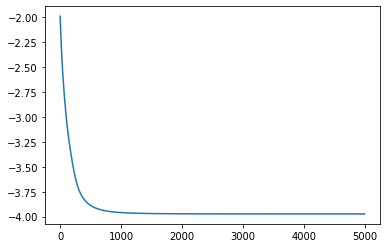


 number of pruning 2 parameters to prune 48 value of cut-off 0.2479781402389699 6.030074347594504

 Final value of the ground-state energy = {loss}  -3.972708751000368


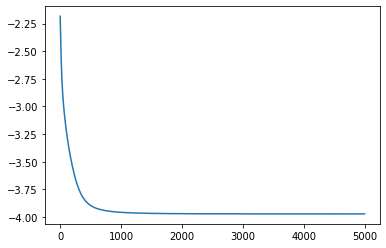


 number of pruning 3 parameters to prune 72 value of cut-off 0.39807620612760264 5.858075040747304

 Final value of the ground-state energy = {loss}  -3.972612384208368


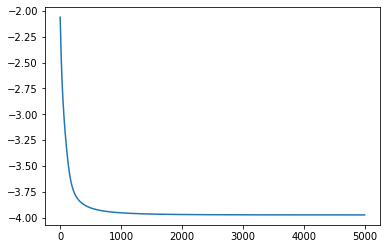


 number of pruning 4 parameters to prune 96 value of cut-off 0.5347042410231031 5.739151762429638

 Final value of the ground-state energy = {loss}  -3.972716742633827


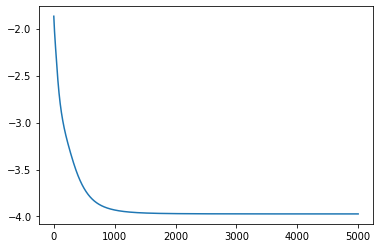


 number of pruning 5 parameters to prune 120 value of cut-off 0.6824786779232016 5.509279310042092

 Final value of the ground-state energy = {loss}  -3.97254850507731


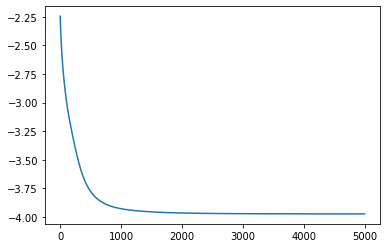


 number of pruning 6 parameters to prune 144 value of cut-off 0.7733444736987228 5.364309665524782

 Final value of the ground-state energy = {loss}  -3.972040606741121


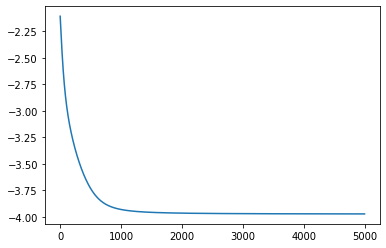


 number of pruning 7 parameters to prune 168 value of cut-off 0.9481610106686322 5.118097412789171

 Final value of the ground-state energy = {loss}  -3.9708998392305266


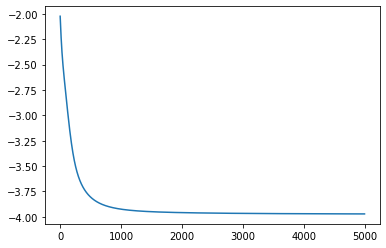


 number of pruning 8 parameters to prune 192 value of cut-off 1.0555285535757946 5.0001993529033415

 Final value of the ground-state energy = {loss}  -3.9708006158291225


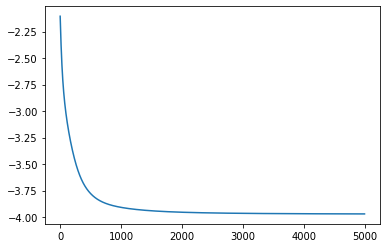


 number of pruning 9 parameters to prune 216 value of cut-off 1.1979496823801612 4.82830711760691

 Final value of the ground-state energy = {loss}  -3.9696854269066


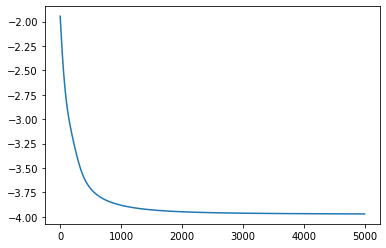


 number of pruning 10 parameters to prune 240 value of cut-off 1.4279500726631293 4.722348444957765

 Final value of the ground-state energy = {loss}  -3.9604065680872957


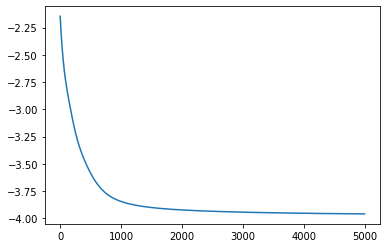


 number of pruning 11 parameters to prune 264 value of cut-off 1.5266675222619415 4.566914854493565

 Final value of the ground-state energy = {loss}  -3.9561302673362486


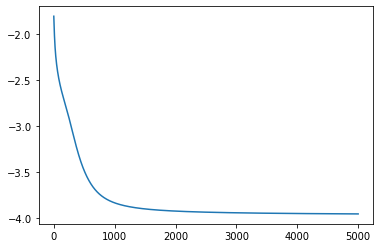


 number of pruning 12 parameters to prune 288 value of cut-off 1.6211065013706554 4.351200337132325

 Final value of the ground-state energy = {loss}  -3.9608693083753015


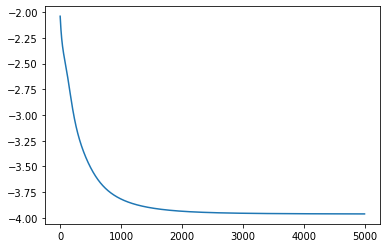


 number of pruning 13 parameters to prune 312 value of cut-off 1.7299193548774268 4.181117482532846

 Final value of the ground-state energy = {loss}  -3.9499475265108446


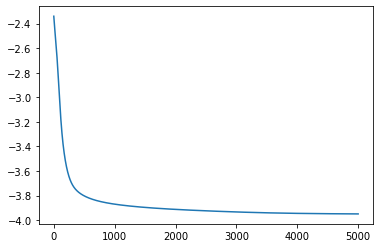


 number of pruning 14 parameters to prune 336 value of cut-off 1.9070690701617365 4.042641900576637

 Final value of the ground-state energy = {loss}  -3.9502822734352105


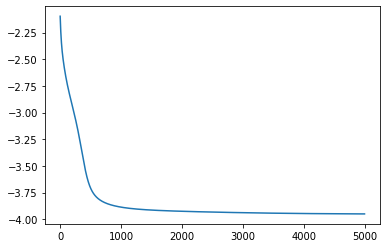


 number of pruning 15 parameters to prune 360 value of cut-off 2.060125140036518 3.921063851354811

 Final value of the ground-state energy = {loss}  -3.945697548012293


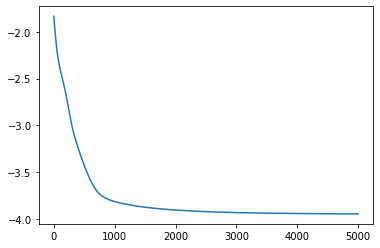


 number of pruning 16 parameters to prune 384 value of cut-off 2.2038971119295745 3.719015419095262

 Final value of the ground-state energy = {loss}  -3.947447689028223


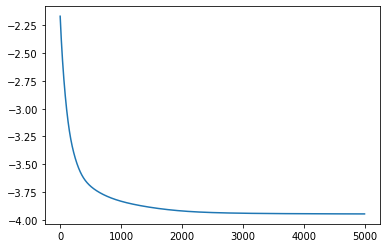


 number of pruning 17 parameters to prune 408 value of cut-off 2.372059206428074 3.5950341727674293

 Final value of the ground-state energy = {loss}  -3.9477668260037757


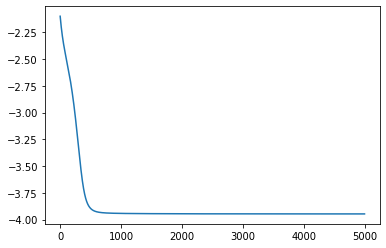


 number of pruning 18 parameters to prune 432 value of cut-off 2.5018408200176934 3.479781653006248

 Final value of the ground-state energy = {loss}  -3.9465814450844445


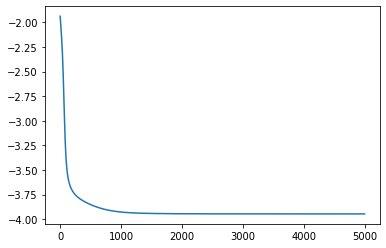


 number of pruning 19 parameters to prune 456 value of cut-off 2.636969873744973 3.338941233612802

 Final value of the ground-state energy = {loss}  -3.9338033602029636


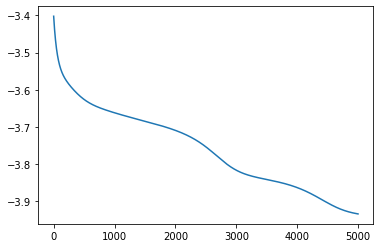

time in seconds=  1000.8769698143005


In [16]:
list_globals = []
list_params = []
list_fidelity = []
list_ent = []
for exp in range(0, exps):
    list_globals_exp = []
    list_params_exp = []
    list_fidelity_exp = []
    list_ent_exp = []
    print ("EXPERIMENT ", exp)
    #generate random initial parameters
    key = random.PRNGKey(exp+ekey)
    key, subkey = random.split(key)
    init_params = 2*pi*random.uniform(subkey, (number_layers, number_parameters))
    list_params_exp.append(init_params)
    
    #initial evaluation of the global energy with the random parameters
    glob0 = circuit_all(init_params)
    list_globals_exp.append(glob0)
    list_params_exp.append(init_params)
    list_fidelity_exp.append(fidelity(init_params))
    
    params = init_params
    for _ in range(steps):
        loss, δp = grad_circuit(params)
        params -= 0.01*δp # Gradient-descent update.
    print("\n" f"Final value of the ground-state energy = {loss} ")
    list_globals_exp.append(loss)
    list_params_exp.append(params)
    list_fidelity_exp.append(fidelity(params))
    
    print ("\n pruning starts")
    for run in range (1, total_pruning_runs):
        glob, pruned_params = pruning(init_params, run)
        list_params_exp.append(pruned_params)
        list_globals_exp.append(glob)
        list_fidelity_exp.append(fidelity(pruned_params))
        
    list_globals.append(list_globals_exp)
    list_params.append(list_params_exp)
    list_fidelity.append(list_fidelity_exp)
    list_ent.append(list_ent_exp)
    

with open('globals.txt', 'a+') as f:
    print (list_globals, file=f)
f.close()

with open('params.txt', 'a+') as f:
    print (list_params, file=f)
f.close()

with open('fidelity.txt', 'a+') as f:
    print (list_fidelity, file=f)
f.close()

with open('ent.txt', 'a+') as f:
    print (list_ent, file=f)
f.close()

end = time.time()
print("time in seconds= ", end - start)

In [18]:
for i in range(1, total_pruning_runs+1):
    print (i)
    print ('exp ', "global energy", "fidelity")
    av = 0
    for exp in range(0, exps):
        float1 = list_globals[exp][i]
        float3 = list_fidelity[exp][i]
        av += list_globals[exp][i]
        format_float1 = "{:.4f}".format(float1)
        format_float3 = "{:.4f}".format(float3)
        print ( exp," ", format_float1, "  ", format_float3 )
    print ("av/exps")
    print (av/exps)

1
exp  global energy fidelity
0   -3.9727    1.0000
av/exps
-3.9727385011123837
2
exp  global energy fidelity
0   -3.9727    1.0000
av/exps
-3.9727419823227472
3
exp  global energy fidelity
0   -3.9727    1.0000
av/exps
-3.972708751000368
4
exp  global energy fidelity
0   -3.9726    1.0000
av/exps
-3.972612384208368
5
exp  global energy fidelity
0   -3.9727    1.0000
av/exps
-3.972716742633827
6
exp  global energy fidelity
0   -3.9725    0.9999
av/exps
-3.97254850507731
7
exp  global energy fidelity
0   -3.9720    0.9998
av/exps
-3.972040606741121
8
exp  global energy fidelity
0   -3.9709    0.9995
av/exps
-3.9708998392305266
9
exp  global energy fidelity
0   -3.9708    0.9992
av/exps
-3.9708006158291225
10
exp  global energy fidelity
0   -3.9697    0.9989
av/exps
-3.9696854269066
11
exp  global energy fidelity
0   -3.9604    0.9960
av/exps
-3.9604065680872957
12
exp  global energy fidelity
0   -3.9561    0.9948
av/exps
-3.9561302673362486
13
exp  global energy fidelity
0   -3.9609    

In [20]:
global_all = [item / global_min for item in list_globals[0]] #renormalize energy values to one
nglobal_all = global_all[1:] # remove the first element which corresponds to the min found with the random initials
nfid = list_fidelity[0][1:] # remove the first element which the first one corresponds to the min found with the random initials

# Results

Below we plot the ground state fidelity and energy after each pruning run. Specifically, we rescale the ground state energy to one. In that way, we can plot both the ground state fidelity and energy after each pruning run.

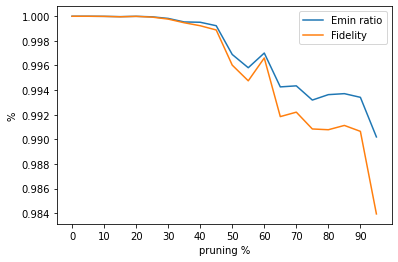

In [21]:
counts = list(range(20))
prec = [item*5 for item in counts]
plt.plot(prec, nglobal_all, label = 'Emin ratio')
plt.plot(prec, nfid, label = 'Fidelity')
plt.xticks(np.arange(0, 100, 10), ["0", "10", "20", "30", "40", "50" , "60" , "70", "80", "90"])
plt.legend()
plt.xlabel("pruning %")
plt.ylabel("%")
plt.legend()
plt.xlabel("pruning %")
plt.show()

At the recent work of<a href="https://www.nature.com/articles/nature23879" title="link"> Kandala et. al. </a>, to get the chemical accuracy for BeH2 molecule they used 28 layers, which translates to 644 parameters. Here, starting from 510 parameters for the exact same BeH2 molecular hamiltonian we can reduce the number of parameters up to 90% and still maintain high values of both the ground state energy and the fidelity! Specifically, pruning 90% of the parameters results to 51 parameters left of the parametrized quantum circuit, which gives approximately 99.2% and 99.4% accuracy on the ground state fidelity and energy, respectively. 

But we can also prune and still be within the chemical accuracy that is usually considered! If we choose to prune 20% of the parameters, we end up with 414 parameters, which is approximately 40% less parameters compared to the aforementioned work. Interestingly, in that case the ground state energy is -3.9727 which is within the chemical accuracy! Also, the ground state fidelity is equal to 1.0000!

Interestingly, the pruning method discussed here could also be applied to any Hamiltonian independent of the symmetries of the system.

We could increase the number of parameters pruned within chemical accuracy for example by further optimizing the hyper parameters, such as the initial random values of the optimization. Finally, it would be highly interesting to combine the pruning method with more efficient optimization strategies, like the  <a href="https://www.nature.com/articles/s41467-019-10988-2" title="link"> adapt-VQE </a>. This would potentially give even higher values of the accuracy for both ground state and energy of the given Hamiltonian with both a less costful classical optimization subroutine and less overall number of parameters. 

### Acknowledgments

I would like to thank Alexandre Dauphin, Patrick Huembeli and Paolo Stornati. Also, I would like to thank ‪Abhinav Kandala for providing us with the BeH2 Hamiltonian.